In [1]:
import re
import os
import random

import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
tf.__version__

'2.6.4'

## Read and inspect the data

In [3]:
# convert train and test csv file into pandas DataFrame
train_df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels_df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [4]:
train_df.shape, test_df.shape, test_labels_df.shape

((159571, 8), (153164, 2), (153164, 7))

In [5]:
# check the train DataFrame
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<AxesSubplot:title={'center':'Distribution of comment types'}>

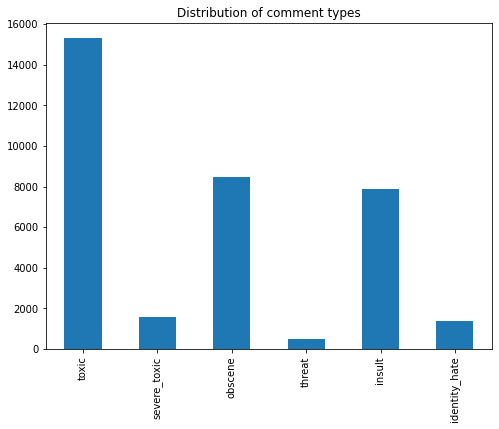

In [6]:
def comment_type_num(dataframe):
    col_name = [col for col in train_df.columns][2:]
    num_type = {}
    for col in col_name:
        num_type[col] = len(np.where(np.array(train_df[col]) == 1)[0])
#     num_type["clean_comments"] = len(dataframe) - sum(num_type.values())
    return num_type
pd.Series(comment_type_num(train_df)).plot(kind="bar", 
                                           title="Distribution of comment types",
                                          figsize=(8, 6))

In [7]:
train_df["comment_text"][:5].to_list()

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

In [8]:
# check the null values in train data
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [9]:
# drop the id column
train_df.drop(["id"], axis=1, inplace=True)

In [10]:
# function for cleaning text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [11]:
train_df["comment_text"] = train_df["comment_text"].map(lambda x: clean_text(x))

In [12]:
# after cleaning
train_df["comment_text"][:5].to_list()

['explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27',
 'd aww he matches this background colour i am seemingly stuck with thanks talk 21 51 january 11 2016 utc',
 'hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info',
 'more i cannot make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yours

In [13]:
# separating sentences and labels into numpy arrays 
total_sentences = train_df["comment_text"].to_numpy()
total_labels = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_numpy()
total_sentences[52000:52005], total_labels[52000:52005]

(array(['please do not vandalize pages as you did with this edit to raccoon city if you continue to do so you will be blocked from editing',
        'jxm i inserted the phrase purporting to examine back in january i believe it is the most appropriate phrasing because 1 pear only claims to be examining psi legitimate scientists don t think that there is any psi to examine 2 even if telekinesis were real pear s experiments wouldn t have proven its existence anyway because of their methodological flaws 3 the reliable sources seem to be suggesting though not outright stating that pear was probably involved in deliberate fraud the fact that one of pear s own staff was an experimental subject who had a significant effect on their results coupled with the fact that pear s results are not reproducible seems to have created some suspicion while i m not proposing that we add pear to one of wikipedia s lists of hoaxes i don t think that it would be appropriate to use any language that might give 

In [14]:
# Split the train data into train and validation data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(total_sentences, total_labels,
                                                                           test_size=0.1, shuffle=True)

In [15]:
train_labels.shape, val_labels.shape

((143613, 6), (15958, 6))

In [16]:
# investigate the properties of sentences in training data
sent_len = [len(sentence) for sentence in train_sentences]
avg_len = np.mean(sent_len)
avg_len, np.max(sent_len)

(376.626955776984, 5121)

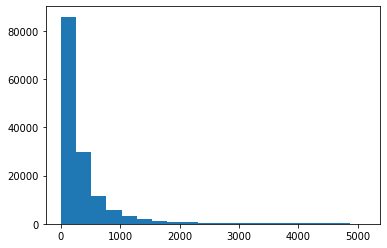

In [17]:
plt.hist(sent_len, bins=20);

In [18]:
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

1299

In [19]:
# creating the instance of TextVectorization class
MAX_TOKENS = 30000
text_vectorizer = TextVectorization(max_tokens=MAX_TOKENS,
                                   output_sequence_length=output_seq_len)

2022-10-10 02:05:59.427916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 02:05:59.524986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 02:05:59.525808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 02:05:59.527032: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
# adpating the class to our train sentences
text_vectorizer.adapt(train_sentences)

2022-10-10 02:06:02.101433: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [21]:
# Test the text vectorizer
target_sent = random.choice(train_sentences)
print(f"Target sentence: {target_sent}\n")
print(f"Length of sentence: {len(target_sent.split())}\n")
print(f"Vectorized text: {text_vectorizer([target_sent])}")

Target sentence: um we know that you are not actually a user we have page histories tl

Length of sentence: 15

Vectorized text: [[3913   55   70 ...    0    0    0]]


In [22]:
# properties of text vectorizer layer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 30000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 1299,
 'pad_to_max_tokens': False}

In [23]:
# create custom text embedding layer
token_embed = layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                              output_dim=256,
                              mask_zero=True,
                              name="token_embedding")

# check the token embedding
print(f"Sentence before vectorization:\n{target_sent}\n")
print(f"Sentence after vectorization:\n{text_vectorizer([target_sent])}\n")
print(f"Sentence after embedding:\n{token_embed(text_vectorizer([target_sent]))}\n")
print(f"Shape of embedding:{token_embed(text_vectorizer([target_sent])).shape}")

Sentence before vectorization:
um we know that you are not actually a user we have page histories tl

Sentence after vectorization:
[[3913   55   70 ...    0    0    0]]

Sentence after embedding:
[[[ 0.02225329  0.00300848 -0.04762442 ... -0.0021467  -0.015899
   -0.01374195]
  [ 0.00910426 -0.03910203 -0.03173553 ...  0.03748348  0.0172089
   -0.01540762]
  [-0.02680397 -0.0326822  -0.00734345 ... -0.03698783 -0.03780667
    0.02987364]
  ...
  [ 0.02682387 -0.00110457  0.01713803 ... -0.0223629  -0.04610497
   -0.00119684]
  [ 0.02682387 -0.00110457  0.01713803 ... -0.0223629  -0.04610497
   -0.00119684]
  [ 0.02682387 -0.00110457  0.01713803 ... -0.0223629  -0.04610497
   -0.00119684]]]

Shape of embedding:(1, 1299, 256)


In [24]:
# Create the Dataset (optimizer input pipeline in TensorFlow)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.int64)>,
 <PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.int64)>)

# Modeling

In [25]:
# set up callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=1) 


In [26]:
# building the first model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.LSTM(64, return_sequences=True)(token_embeddings)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation="sigmoid", name="lstm_output")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [27]:
# compile the model
model_1.compile(loss="binary_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [28]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 1299)              0         
_________________________________________________________________
token_embedding (Embedding)  (None, 1299, 256)         7680000   
_________________________________________________________________
lstm (LSTM)                  (None, 1299, 64)          82176     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3250  

In [29]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                             epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1 * len(val_dataset)),
                             callbacks=[early_stopping])

Epoch 1/3


2022-10-10 02:06:17.949776: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4488/4488 [==============================] - 129s 27ms/step - loss: 0.0627 - accuracy: 0.9705 - val_loss: 0.0493 - val_accuracy: 0.9936
Epoch 2/3
4488/4488 [==============================] - 125s 28ms/step - loss: 0.0430 - accuracy: 0.9909 - val_loss: 0.0451 - val_accuracy: 0.9936


In [30]:
# plot the loss
def plot_loss_curves(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

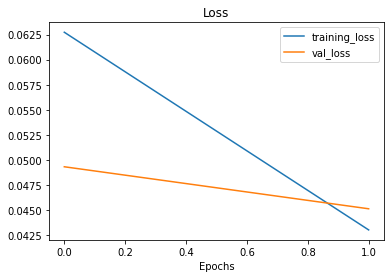

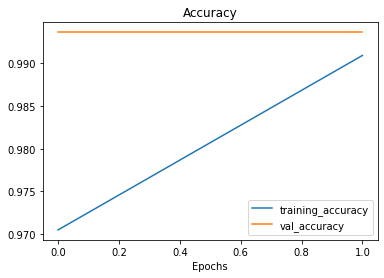

In [31]:
plot_loss_curves(history_model_1)

# Evaluation 

In [32]:
model_1.evaluate(val_dataset)

499/499 [==============================] - 5s 11ms/step - loss: 0.0468 - accuracy: 0.9932


[0.04680977761745453, 0.993232250213623]

# Save model

In [144]:
# save_dir = "/kaggle/working/"
# model_1.save(save_dir)

# Predicting on some texts from validation dataset

In [33]:
y_pred_probs = model_1.predict(val_dataset)
y_pred_probs

array([[3.4658670e-02, 1.3975715e-04, 5.4742461e-03, 2.2070224e-03,
        6.6042677e-03, 2.2350941e-03],
       [1.3871535e-04, 4.8677751e-09, 1.5223745e-05, 1.9699212e-06,
        9.5488513e-06, 1.9885263e-06],
       [4.2481977e-05, 8.6478530e-10, 3.6823551e-06, 5.4117197e-07,
        2.1535034e-06, 5.2750562e-07],
       ...,
       [2.4904200e-04, 8.7601828e-09, 2.3963263e-05, 3.2879807e-06,
        1.5616493e-05, 3.6326373e-06],
       [1.4908318e-01, 2.6037305e-04, 1.4797957e-02, 4.2676930e-03,
        2.9314667e-02, 9.7098472e-03],
       [6.6195987e-04, 3.5069245e-08, 5.0624920e-05, 7.3450055e-06,
        4.7332218e-05, 8.9088362e-06]], dtype=float32)

In [34]:
y_preds = np.where(y_pred_probs > 0.5, 1, 0)
y_preds

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [131]:
#y_preds[21:30]

In [130]:
#val_labels[21:30]

In [138]:
for i in range(21, 30):
    val_sent = val_sentences[i]
    val_label = val_labels[i]
    y_pred = y_preds[i]
    y_pred_prob = y_pred_probs[i]
    print(f"Sentence:\n{val_sent}\n")
    print(f"Prediction probability:\n{[{class_names[i]: y_pred_prob[i] for i in range(len(class_names))}]}")
    print(f"Predictions:\n{[{class_names[i]: y_pred[i] for i in range(len(class_names))}]}")
    print(f"Actual predictions:\n{[{class_names[i]: val_label[i] for i in range(len(class_names))}]}\n")
    print("***************************************************************************************************\n")

Sentence:
ready to fuck up any who oppose me

Prediction probability:
[{'toxic': 0.985622, 'severe_toxic': 0.08646851, 'obscene': 0.9777541, 'threat': 0.004194929, 'insult': 0.5628157, 'identity_hate': 0.012250942}]
Predictions:
[{'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}]
Actual predictions:
[{'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 0, 'identity_hate': 0}]

***************************************************************************************************

Sentence:
hey cool happy birthday

Prediction probability:
[{'toxic': 0.006386291, 'severe_toxic': 5.929683e-06, 'obscene': 0.0007857666, 'threat': 0.00021693566, 'insult': 0.00074551767, 'identity_hate': 0.00020971886}]
Predictions:
[{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}]
Actual predictions:
[{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}]

******************

# Prediction on user-input sentence

In [121]:
class_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
def get_comment_class(input_text):
    pred_probs =  model_1.predict([input_text])[0]
    probs = np.where(pred_probs > 0.5,1,0)
    for i, j in zip(class_names, probs):
        if j == 1:
            print(f"{i}:\t YES")
        if j == 0:
            print(f"{i}:\t NO")
            
            
input_text = "you fucking bitch."
get_comment_class(input_text)

toxic:	 YES
severe_toxic:	 NO
obscene:	 YES
threat:	 NO
insult:	 YES
identity_hate:	 NO
